In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import load, plot_sample, train

from datetime import datetime
import os
import time

import matplotlib.pyplot as pyplot
import tensorflow as tf

In [3]:
os.environ["FTRAIN"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/training.csv"
os.environ["FTEST"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/test.csv"

In [4]:
X, y = load()
X_test, _ = load(test=True)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X_test.shape == {}; X_test.min == {:.3f}; X_test.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
X_test.shape == (1783, 9216); X_test.min == 0.000; X_test.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [ ]:
num_epoch = 500

y_pred = train(num_epoch, X, y, X_test, "xavier_initialization_with_validation")

Epoch:    0	Training Loss: 0.5230889	Elapsed Time(ms):    113
Epoch:    1	Training Loss: 0.3304610	Elapsed Time(ms):     86
Epoch:    2	Training Loss: 0.1699799	Elapsed Time(ms):     85
Epoch:    3	Training Loss: 0.0923512	Elapsed Time(ms):     91
Epoch:    4	Training Loss: 0.0833572	Elapsed Time(ms):     86
Epoch:    5	Training Loss: 0.0769508	Elapsed Time(ms):     85
Epoch:    6	Training Loss: 0.0700255	Elapsed Time(ms):     91
Epoch:    7	Training Loss: 0.0606936	Elapsed Time(ms):     85
Epoch:    8	Training Loss: 0.0575565	Elapsed Time(ms):     86
Epoch:    9	Training Loss: 0.0525221	Elapsed Time(ms):     95
Epoch:   10	Training Loss: 0.0478031	Elapsed Time(ms):     89
Epoch:   11	Training Loss: 0.0401399	Elapsed Time(ms):     85
Epoch:   12	Training Loss: 0.0380120	Elapsed Time(ms):     92
Epoch:   13	Training Loss: 0.0361167	Elapsed Time(ms):     88
Epoch:   14	Training Loss: 0.0336417	Elapsed Time(ms):     89
Epoch:   15	Training Loss: 0.0316371	Elapsed Time(ms):     91
Epoch:  

Epoch:  133	Training Loss: 0.0087103	Elapsed Time(ms):    123
Epoch:  134	Training Loss: 0.0086849	Elapsed Time(ms):    129
Epoch:  135	Training Loss: 0.0086598	Elapsed Time(ms):    113
Epoch:  136	Training Loss: 0.0086349	Elapsed Time(ms):     97
Epoch:  137	Training Loss: 0.0086103	Elapsed Time(ms):    102
Epoch:  138	Training Loss: 0.0085859	Elapsed Time(ms):    117
Epoch:  139	Training Loss: 0.0085617	Elapsed Time(ms):     93
Epoch:  140	Training Loss: 0.0085377	Elapsed Time(ms):     91
Epoch:  141	Training Loss: 0.0085139	Elapsed Time(ms):     87
Epoch:  142	Training Loss: 0.0084903	Elapsed Time(ms):    127
Epoch:  143	Training Loss: 0.0084669	Elapsed Time(ms):    151
Epoch:  144	Training Loss: 0.0084436	Elapsed Time(ms):     88
Epoch:  145	Training Loss: 0.0084205	Elapsed Time(ms):     95
Epoch:  146	Training Loss: 0.0083977	Elapsed Time(ms):    127
Epoch:  147	Training Loss: 0.0083750	Elapsed Time(ms):    100
Epoch:  148	Training Loss: 0.0083525	Elapsed Time(ms):    123
Epoch:  

Epoch:  267	Training Loss: 0.0065504	Elapsed Time(ms):    108
Epoch:  268	Training Loss: 0.0065401	Elapsed Time(ms):    115
Epoch:  269	Training Loss: 0.0065299	Elapsed Time(ms):    112
Epoch:  270	Training Loss: 0.0065196	Elapsed Time(ms):    111
Epoch:  271	Training Loss: 0.0065095	Elapsed Time(ms):    100
Epoch:  272	Training Loss: 0.0064994	Elapsed Time(ms):    101
Epoch:  273	Training Loss: 0.0064893	Elapsed Time(ms):    114
Epoch:  274	Training Loss: 0.0064793	Elapsed Time(ms):    119
Epoch:  275	Training Loss: 0.0064693	Elapsed Time(ms):    111
Epoch:  276	Training Loss: 0.0064594	Elapsed Time(ms):    109
Epoch:  277	Training Loss: 0.0064495	Elapsed Time(ms):    124
Epoch:  278	Training Loss: 0.0064397	Elapsed Time(ms):     96
Epoch:  279	Training Loss: 0.0064299	Elapsed Time(ms):    122
Epoch:  280	Training Loss: 0.0064201	Elapsed Time(ms):    110
Epoch:  281	Training Loss: 0.0064104	Elapsed Time(ms):     98
Epoch:  282	Training Loss: 0.0064008	Elapsed Time(ms):    102
Epoch:  

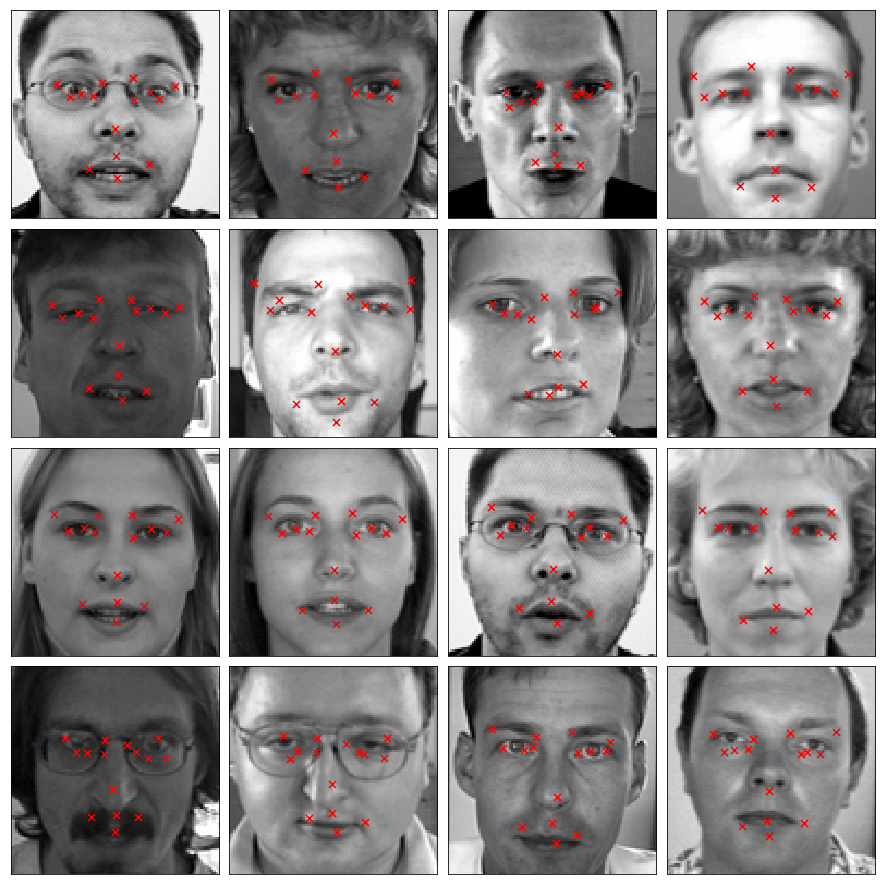

In [6]:
fig = pyplot.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)
    
pyplot.show()

In [11]:
import numpy as np
a = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2]])

In [19]:
y.shape

(2140, 30)